<a href="https://colab.research.google.com/github/istiaqahmedfahim/cloud_workload_forecasting/blob/main/Workload_forecasting_of_cloud_%7C_simple_BiLSTM_based.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'cloud-computing-history-data:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4018029%2F6990719%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240205%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240205T135728Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D564eb1eeaa95a68dfa49ca00f5c37fa544017fd2a1ffb67db8a68909cbbaf63d2db185cdbf0c80830a9c49c5132f70e531cd6a9c3ae1c5f2a8d4d67ea1b8e7092aa56f8136de004070f1adb6445c97323c900e7e4e9f0c99ed63bdeb3ce5084b7b589c4321701887936aaa34a97c71a822e02109293d805c6a8c3e8fd3ad5aef8ae5594d9ef979ccd918fad0fa9d8852b1dbc7f64e095cbe403312281e855848f7dde4556ddc04d3879e5752cc6fa8d8e1d5b2e9a032e38ef76409d1d9ec7c887c0a3fa9bf7e90d4f52a67af52404d0db0c7710aff0a613448f5ed1a5012a3736bd6af17aeafab5dbaaaafa1c52ada1be18d99a0adc3504a51c116bea4cc3c05'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 143815 bytes downloaded
Downloaded and uncompressed: cloud-computing-history-data
Data source import complete.


In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pylab
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import tensorflow as tf
rcParams['figure.figsize'] = 20, 16

In [3]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
#from keras.callbacks import EarlyStopping
from keras.layers import ConvLSTM2D

In [4]:
df = pd.read_csv("/kaggle/input/cloud-computing-history-data/43.csv")
df

,Timestamp [ms],CPU cores,CPU capacity provisioned [MHZ],CPU usage [MHZ],CPU usage [%],Memory capacity provisioned [KB],Memory usage [KB],Disk read throughput [KB/s],Disk write throughput [KB/s],Network received throughput [KB/s],Network transmitted throughput [KB/s]
0,1376314846,2,5851.998636,3.901332,0.066667,2097152.0,106254.133333,7.933333,1.066667,0.000000,0.000000
1,1376315146,2,5851.998636,0.000000,0.000000,2097152.0,79689.600000,0.000000,1.000000,0.000000,0.000000
2,1376315446,2,5851.998636,9.753331,0.166667,2097152.0,62912.000000,0.000000,0.066667,0.000000,0.000000
3,1376315746,2,5851.998636,0.000000,0.000000,2097152.0,97865.333333,0.000000,0.066667,0.000000,0.000000
4,1376316046,2,5851.998636,0.000000,0.000000,2097152.0,127225.333333,1.933333,0.333333,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
8627,1378905598,2,5851.998944,76.075986,1.300000,2097152.0,329950.133333,0.333333,561.866667,581.800000,18.400000
8628,1378905898,2,5851.998944,54.618657,0.933333,2097152.0,244665.333333,1.800000,1.133333,2.466667,1.066667
8629,1378906198,2,5851.998944,58.519989,1.000000,2097152.0,139808.800000,0.200000,0.866667,2.400000,1.066667
8630,1378906498,2,5851.998944,325.761275,5.566667,2097152.0,325755.733333,1029.666667,55.466667,2.466667,1.533333


In [5]:
Sum_disk=(df["Disk read throughput [KB/s]"] + df["Disk write throughput [KB/s]"])
df["Disk I/O"]=Sum_disk
df["Disk I/O"]=((df["Disk I/O"]-df["Disk I/O"].min())/(df["Disk I/O"].max()-df["Disk I/O"].min()))*20
df

,Timestamp [ms],CPU cores,CPU capacity provisioned [MHZ],CPU usage [MHZ],CPU usage [%],Memory capacity provisioned [KB],Memory usage [KB],Disk read throughput [KB/s],Disk write throughput [KB/s],Network received throughput [KB/s],Network transmitted throughput [KB/s],Disk I/O
0,1376314846,2,5851.998636,3.901332,0.066667,2097152.0,106254.133333,7.933333,1.066667,0.000000,0.000000,0.022571
1,1376315146,2,5851.998636,0.000000,0.000000,2097152.0,79689.600000,0.000000,1.000000,0.000000,0.000000,0.002508
2,1376315446,2,5851.998636,9.753331,0.166667,2097152.0,62912.000000,0.000000,0.066667,0.000000,0.000000,0.000167
3,1376315746,2,5851.998636,0.000000,0.000000,2097152.0,97865.333333,0.000000,0.066667,0.000000,0.000000,0.000167
4,1376316046,2,5851.998636,0.000000,0.000000,2097152.0,127225.333333,1.933333,0.333333,0.000000,0.000000,0.005684
...,...,...,...,...,...,...,...,...,...,...,...,...
8627,1378905598,2,5851.998944,76.075986,1.300000,2097152.0,329950.133333,0.333333,561.866667,581.800000,18.400000,1.409906
8628,1378905898,2,5851.998944,54.618657,0.933333,2097152.0,244665.333333,1.800000,1.133333,2.466667,1.066667,0.007356
8629,1378906198,2,5851.998944,58.519989,1.000000,2097152.0,139808.800000,0.200000,0.866667,2.400000,1.066667,0.002675
8630,1378906498,2,5851.998944,325.761275,5.566667,2097152.0,325755.733333,1029.666667,55.466667,2.466667,1.533333,2.721338


# choosing the target feature

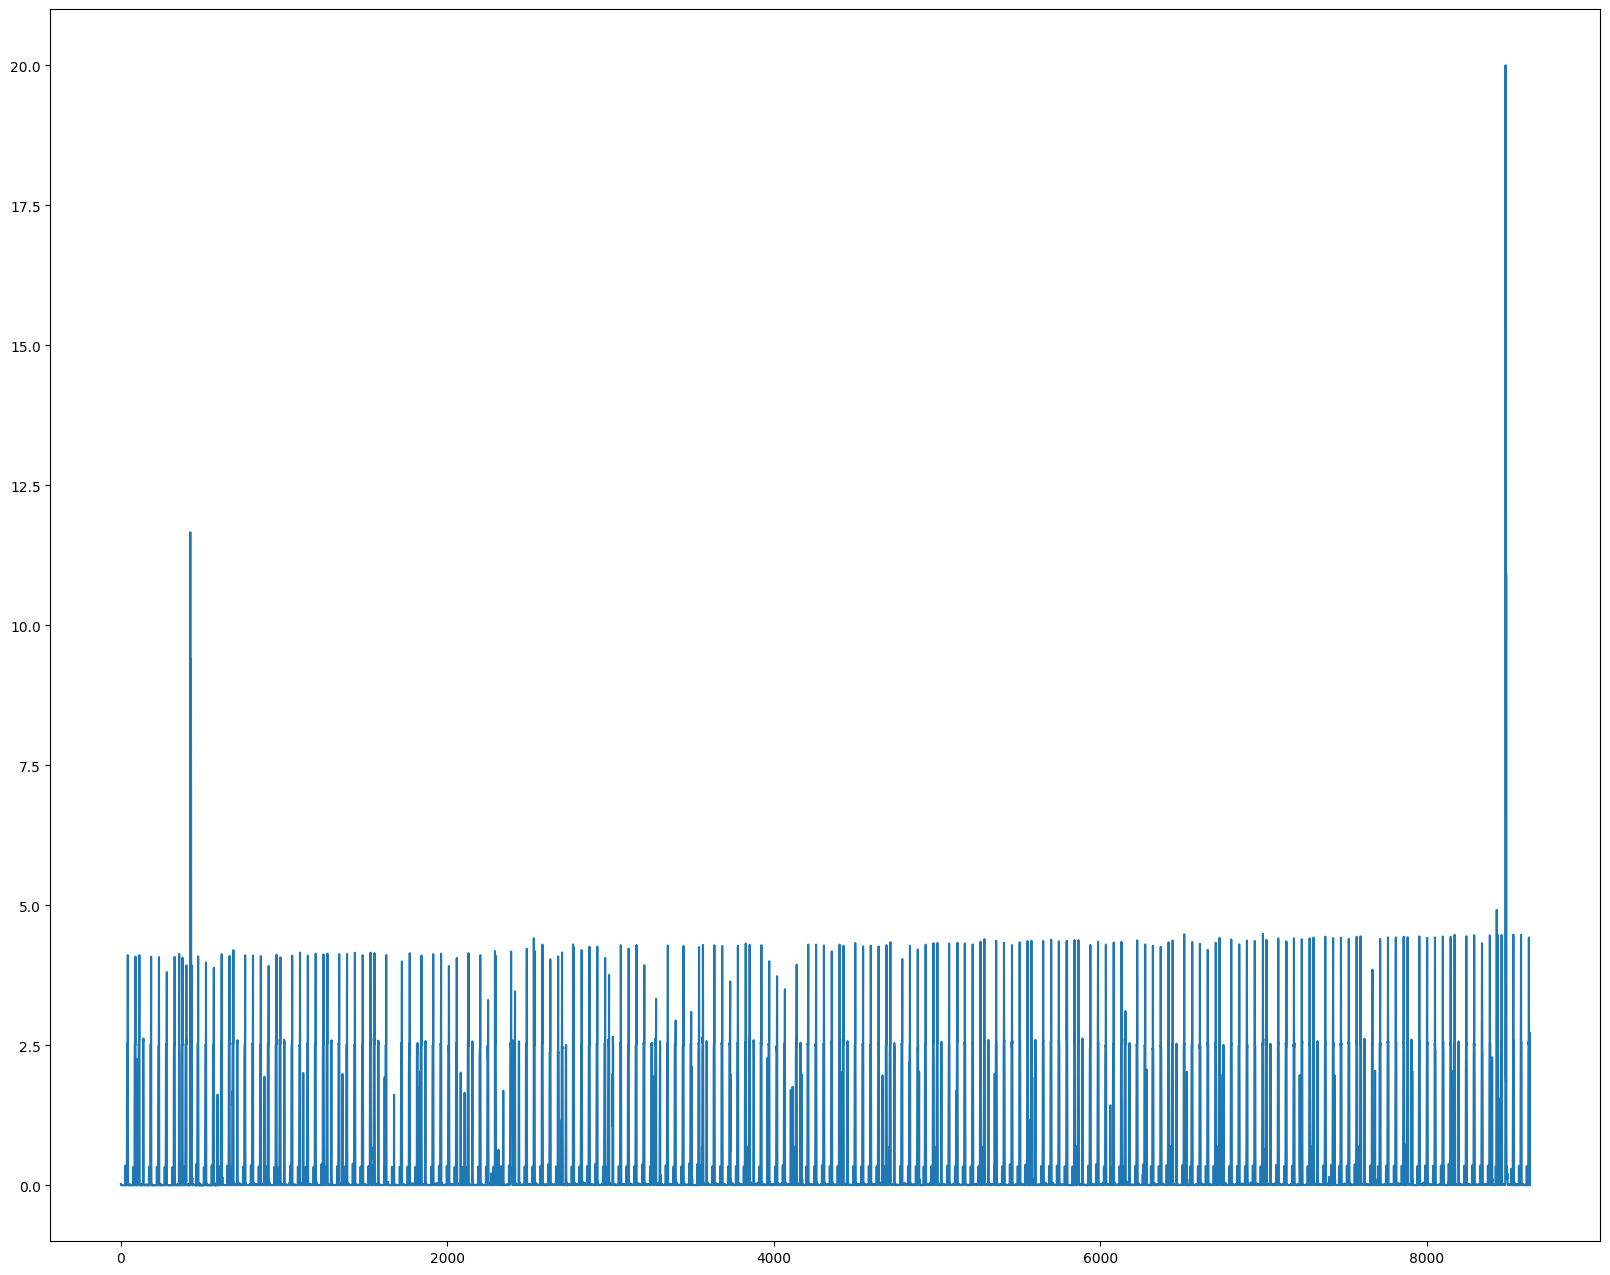

In [6]:
df1 = df['Disk I/O']
df1=df1.to_frame()
plt.plot(df1)
dataset = df1.values
dataset = dataset.astype('float32') #COnvert values to float

# data normalization

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer
dataset = scaler.fit_transform(dataset)

# Train test split

In [8]:
train_size = int(len(dataset) * 0.65)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# define window function

In [9]:
def to_sequences(dataset, seq_size=1):
    x = []
    y = []

    for i in range(len(dataset)-seq_size-1):
        #print(i)
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])

    return np.array(x),np.array(y)

# Windowing the data|Preprocess before model input

In [10]:
seq_size = 30  # Number of time steps to look back
#Larger sequences (look further back) may improve forecasting.

trainX, trainY = to_sequences(train, seq_size)
testX, testY = to_sequences(test, seq_size)

In [11]:
print("Shape of training set: {}".format(trainX.shape))
print("Shape of test set: {}".format(testX.shape))

Shape of training set: (5579, 30)
Shape of test set: (2991, 30)


In [12]:
# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# Define the model

In [13]:
# model = Sequential()
# model.add(LSTM(50,return_sequences=True, input_shape=(None, seq_size)))
# model.add(LSTM(units=50))
# model.add(Dense(1))
#model.compile(loss='mean_squared_error', optimizer='adam')

In [14]:
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Bidirectional, LSTM, Dense

In [17]:
model2= tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(LSTM(64, activation='relu',input_shape=[None, seq_size])),
  tf.keras.layers.Dense(1,'linear')
])

In [ ]:
# model3 = tf.keras.models.Sequential([
#   tf.keras.layers.GRU(64,activation="relu", input_shape=[None, seq_size]),
#   tf.keras.layers.Dense(1,'linear')
# ])

In [ ]:
# import tensorflow as tf
# from tensorflow.keras.layers import Layer, Attention

# class AttentionLayer(Layer):
#     def __init__(self, **kwargs):
#         super(AttentionLayer, self).__init__(**kwargs)

#     def build(self, input_shape):
#         self.W_q = self.add_weight(name="W_q", shape=(input_shape[-1], input_shape[-1]), initializer="uniform", trainable=True)
#         self.W_k = self.add_weight(name="W_k", shape=(input_shape[-1], input_shape[-1]), initializer="uniform", trainable=True)
#         self.V = self.add_weight(name="V", shape=(input_shape[-1], 1), initializer="uniform", trainable=True)
#         super(AttentionLayer, self).build(input_shape)

#     def call(self, x):
#         q = tf.matmul(x, self.W_q)
#         k = tf.matmul(x, self.W_k)
#         scores = tf.matmul(tf.nn.tanh(q + k), self.V)
#         attention_weights = tf.nn.softmax(scores, axis=-2)
#         context_vector = attention_weights * x
#         return context_vector

#     def compute_output_shape(self, input_shape):
#         return input_shape

# seq_size = 30  # Replace with your sequence size

# model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv1D(filters=64, kernel_size=5, strides=1, padding="causal", activation="relu", input_shape=[None, seq_size]),
#     tf.keras.layers.Bidirectional(LSTM(64, activation='relu', return_sequences=True)),
#     tf.keras.layers.LSTM(64, activation="relu", return_sequences=True),
#     tf.keras.layers.LSTM(64, activation="relu", return_sequences=True),
#     tf.keras.layers.GRU(64, activation="relu", return_sequences=True),
#     AttentionLayer(),  # Add Attention Layer
#     tf.keras.layers.Bidirectional(LSTM(50, activation="relu")),  # Return sequences here
#     tf.keras.layers.Dense(1, 'linear')
# ])

In [18]:
model2.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

In [19]:
# Compile the model
model2.compile(optimizer='adam', loss='mean_squared_error',metrics=['mae','mse'])

# Model Fitting

In [20]:
history = model2.fit(trainX, trainY, validation_data=(testX, testY),
          verbose=2, epochs=100)

Epoch 1/100
175/175 - 7s - loss: 0.0013 - mae: 0.0217 - mse: 0.0013 - val_loss: 0.0012 - val_mae: 0.0168 - val_mse: 0.0012 - 7s/epoch - 38ms/step
Epoch 2/100
175/175 - 1s - loss: 7.5482e-04 - mae: 0.0153 - mse: 7.5482e-04 - val_loss: 0.0010 - val_mae: 0.0164 - val_mse: 0.0010 - 1s/epoch - 7ms/step
Epoch 3/100
175/175 - 2s - loss: 6.7101e-04 - mae: 0.0137 - mse: 6.7101e-04 - val_loss: 9.3951e-04 - val_mae: 0.0135 - val_mse: 9.3951e-04 - 2s/epoch - 11ms/step
Epoch 4/100
175/175 - 1s - loss: 6.2492e-04 - mae: 0.0128 - mse: 6.2492e-04 - val_loss: 9.0930e-04 - val_mae: 0.0137 - val_mse: 9.0930e-04 - 1s/epoch - 7ms/step
Epoch 5/100
175/175 - 1s - loss: 5.9629e-04 - mae: 0.0126 - mse: 5.9629e-04 - val_loss: 8.9341e-04 - val_mae: 0.0133 - val_mse: 8.9341e-04 - 1s/epoch - 6ms/step
Epoch 6/100
175/175 - 1s - loss: 5.7759e-04 - mae: 0.0124 - mse: 5.7759e-04 - val_loss: 8.7676e-04 - val_mae: 0.0134 - val_mse: 8.7676e-04 - 1s/epoch - 7ms/step
Epoch 7/100
175/175 - 1s - loss: 5.5461e-04 - mae: 0.012

Prediction using learned model

In [21]:
train_mae = history.history["mae"]
val_mae = history.history["val_mae"]

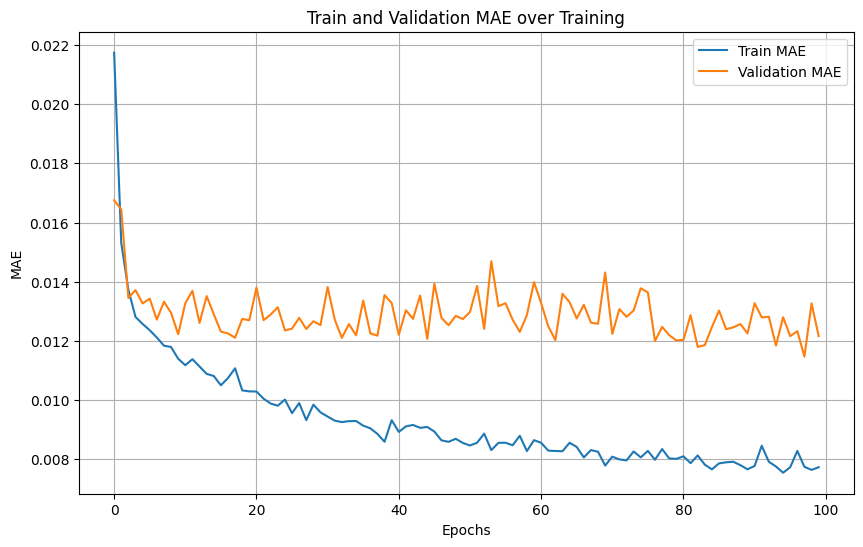

In [22]:
# Figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot train and validation MAE over epochs
ax.plot(range(len(train_mae)), train_mae, label="Train MAE")
ax.plot(range(len(val_mae)), val_mae, label="Validation MAE")

# Customize labels and title
ax.set_xlabel("Epochs")
ax.set_ylabel("MAE")
ax.set_title("Train and Validation MAE over Training")

# Add legend and grid
ax.legend()
ax.grid(True)

# Show the plot
plt.show()

In [23]:
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

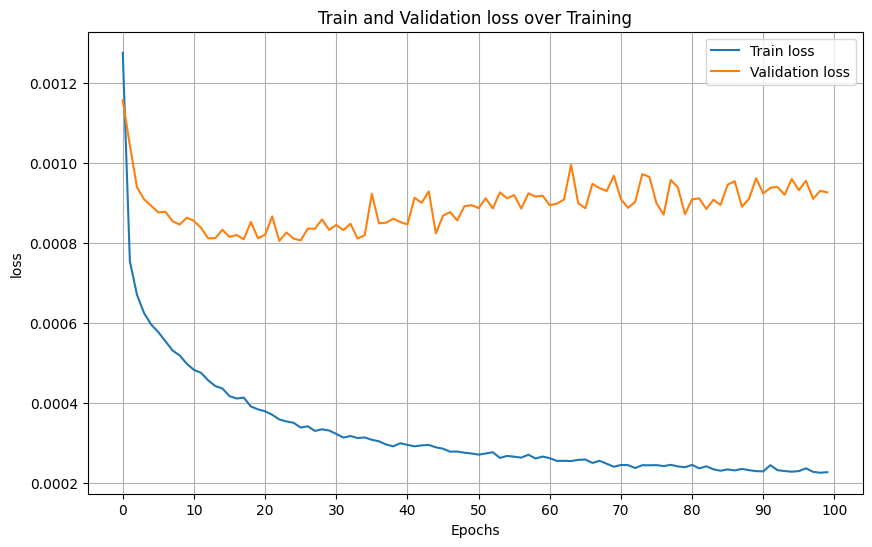

In [24]:
# Figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot train and validation MAE over epochs
ax.plot(range(len(train_loss)), train_loss, label="Train loss")
ax.plot(range(len(val_loss)), val_loss, label="Validation loss")

# Customize labels and title
ax.set_xlabel("Epochs")
ax.set_ylabel("loss")
ax.set_title("Train and Validation loss over Training")
plt.xticks(range(0, 101, 10))
# Add legend and grid
ax.legend()
ax.grid(True)

# Show the plot
plt.show()

In [25]:
min_val_MAE = min(history.history['val_mae'])
min_mae_epoch = np.argmin(history.history['val_mae'])
print(f"Minimum Validation MAE {min_val_MAE}")
print(f"Minimum Validation MAE at epoch {min_mae_epoch}")
min_val_loss = min(history.history['loss'])
min_loss_epoch = np.argmin(history.history['val_loss'])
print(f"Minimum Validation loss {min_val_loss}")
print(f"Minimum Validation loss at epoch {min_loss_epoch}")

Minimum Validation MAE 0.01147253718227148
Minimum Validation MAE at epoch 97
Minimum Validation loss 0.00022603673278354108
Minimum Validation loss at epoch 22


In [27]:
trainPredict = model2.predict(trainX)
testPredict = model2.predict(testX)

94/94 [==============================] - 0s 2ms/step


From Normalized data to Actual data transformation

In [28]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

RMSE Calculation

In [29]:
import math
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

Train Score: 0.29 RMSE


In [30]:
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 0.61 RMSE


In [31]:
# calculate root mean absoulute error
from sklearn.metrics import mean_absolute_error
# Calculate MAE using scikit-learn
mae = mean_absolute_error(trainY[0],trainPredict[:,0])

print(f"Mean Absolute Error: {mae}")

# Calculate MAE using scikit-learn
mae = mean_absolute_error(testY[0],testPredict[:,0])

print(f"Mean Absolute Error on test data: {mae}")



Mean Absolute Error: 0.13534146316666862
Mean Absolute Error on test data: 0.24326366269099983


In [32]:
from sklearn.metrics import mean_squared_error
# Calculate MSE
mse = mean_squared_error(trainY[0],trainPredict[:,0])
print(f"Mean Squared Error (MSE) of train: {mse}")
mse = mean_squared_error(testY[0],testPredict[:,0])
print(f"Mean Squared Error (MSE) of test: {mse}")

Mean Squared Error (MSE) of train: 0.08329035210394929
Mean Squared Error (MSE) of test: 0.37077083329029753


In [33]:
# shift train predictions for plotting
#we must shift the predictions so that they align on the x-axis with the original dataset.
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[seq_size:len(trainPredict)+seq_size, :] = trainPredict

In [34]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(seq_size*2)+1:len(dataset)-1, :] = testPredict

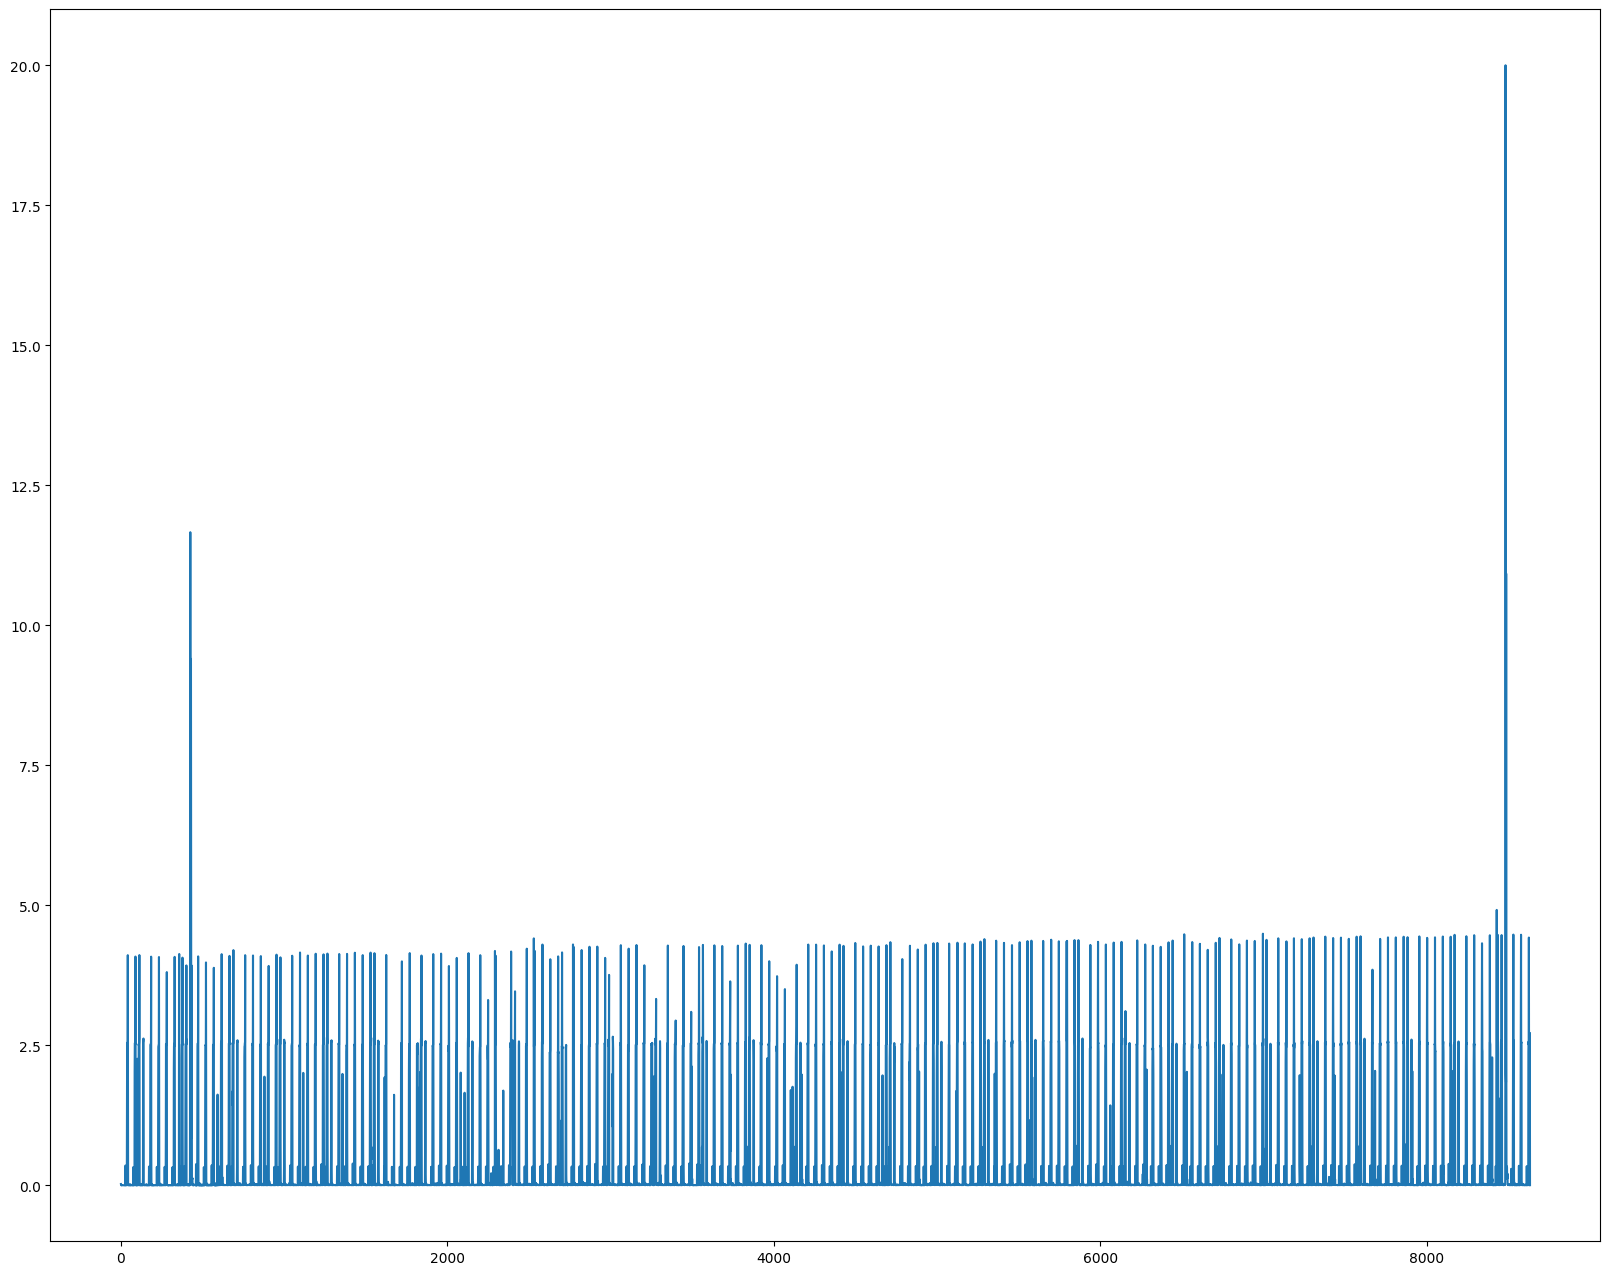

In [35]:
plt.figure()
plt.plot(scaler.inverse_transform(dataset))
plt.show()

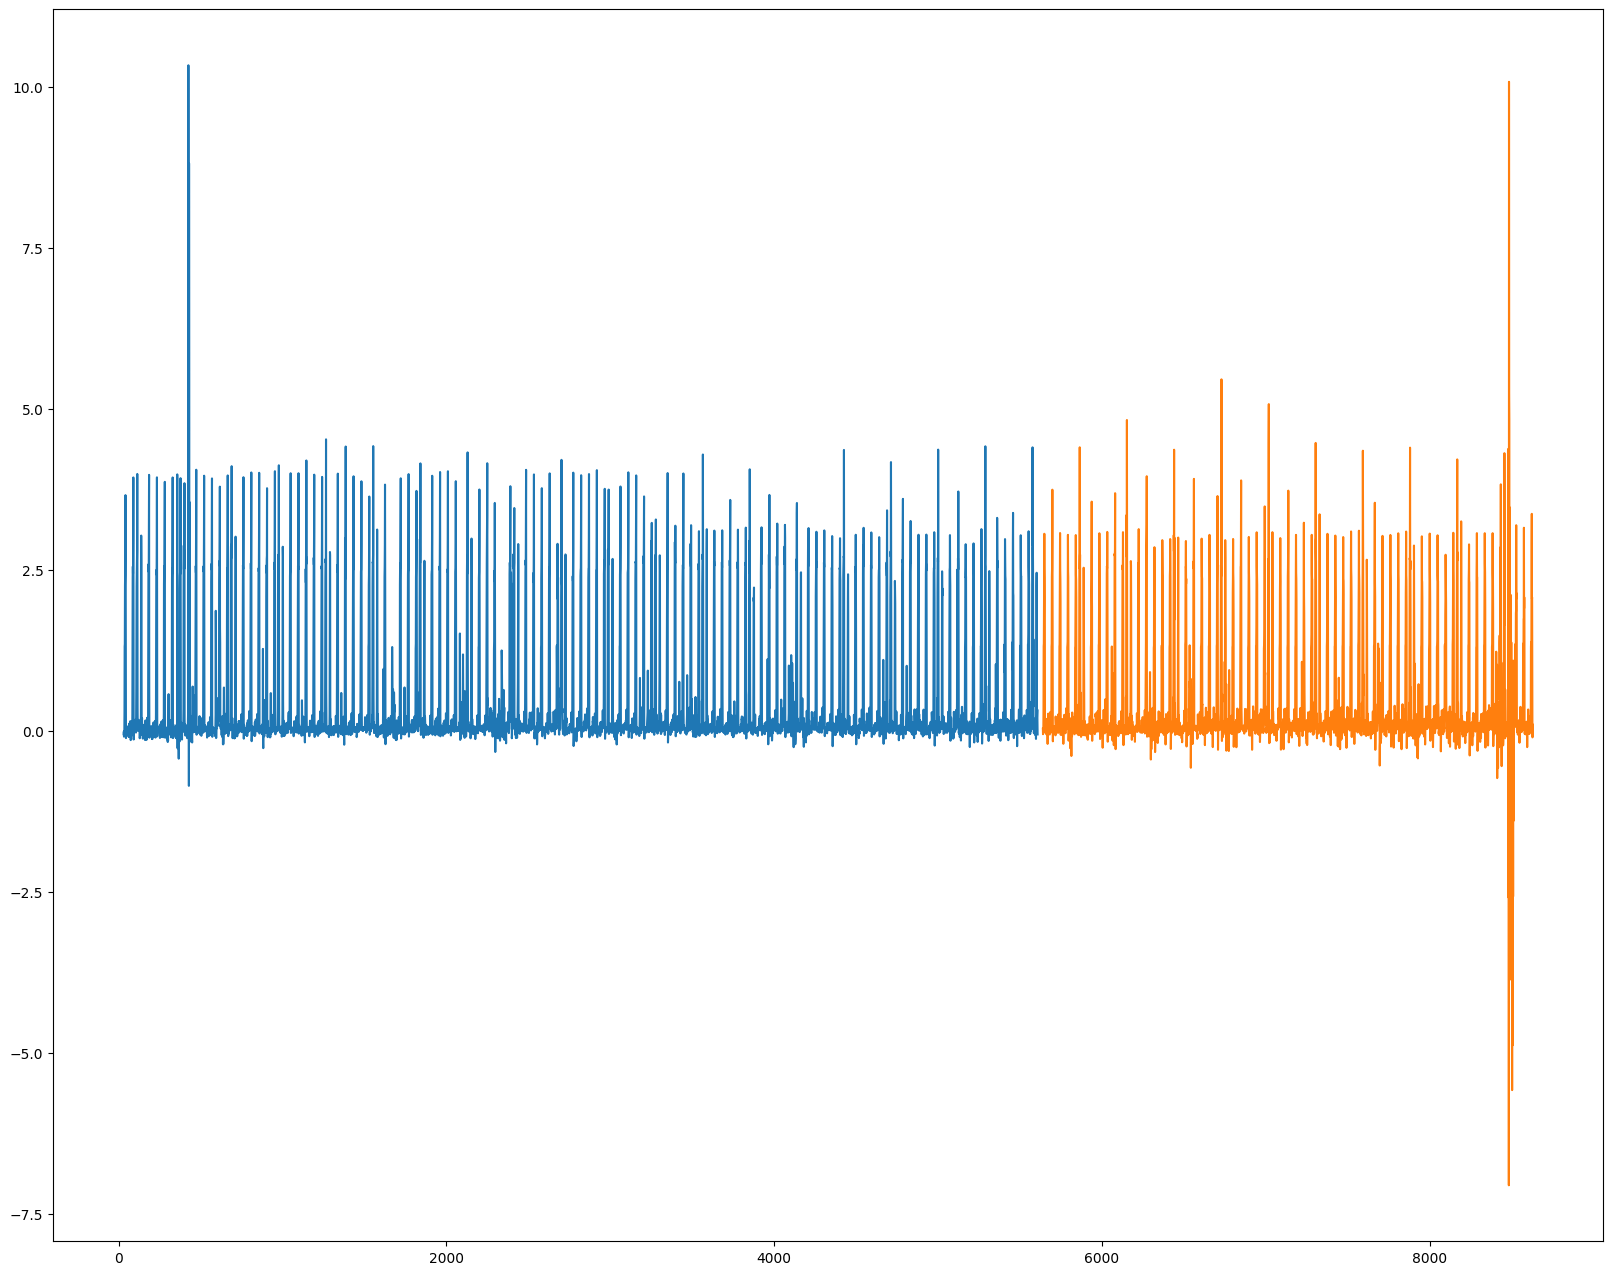

In [36]:
plt.figure()
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

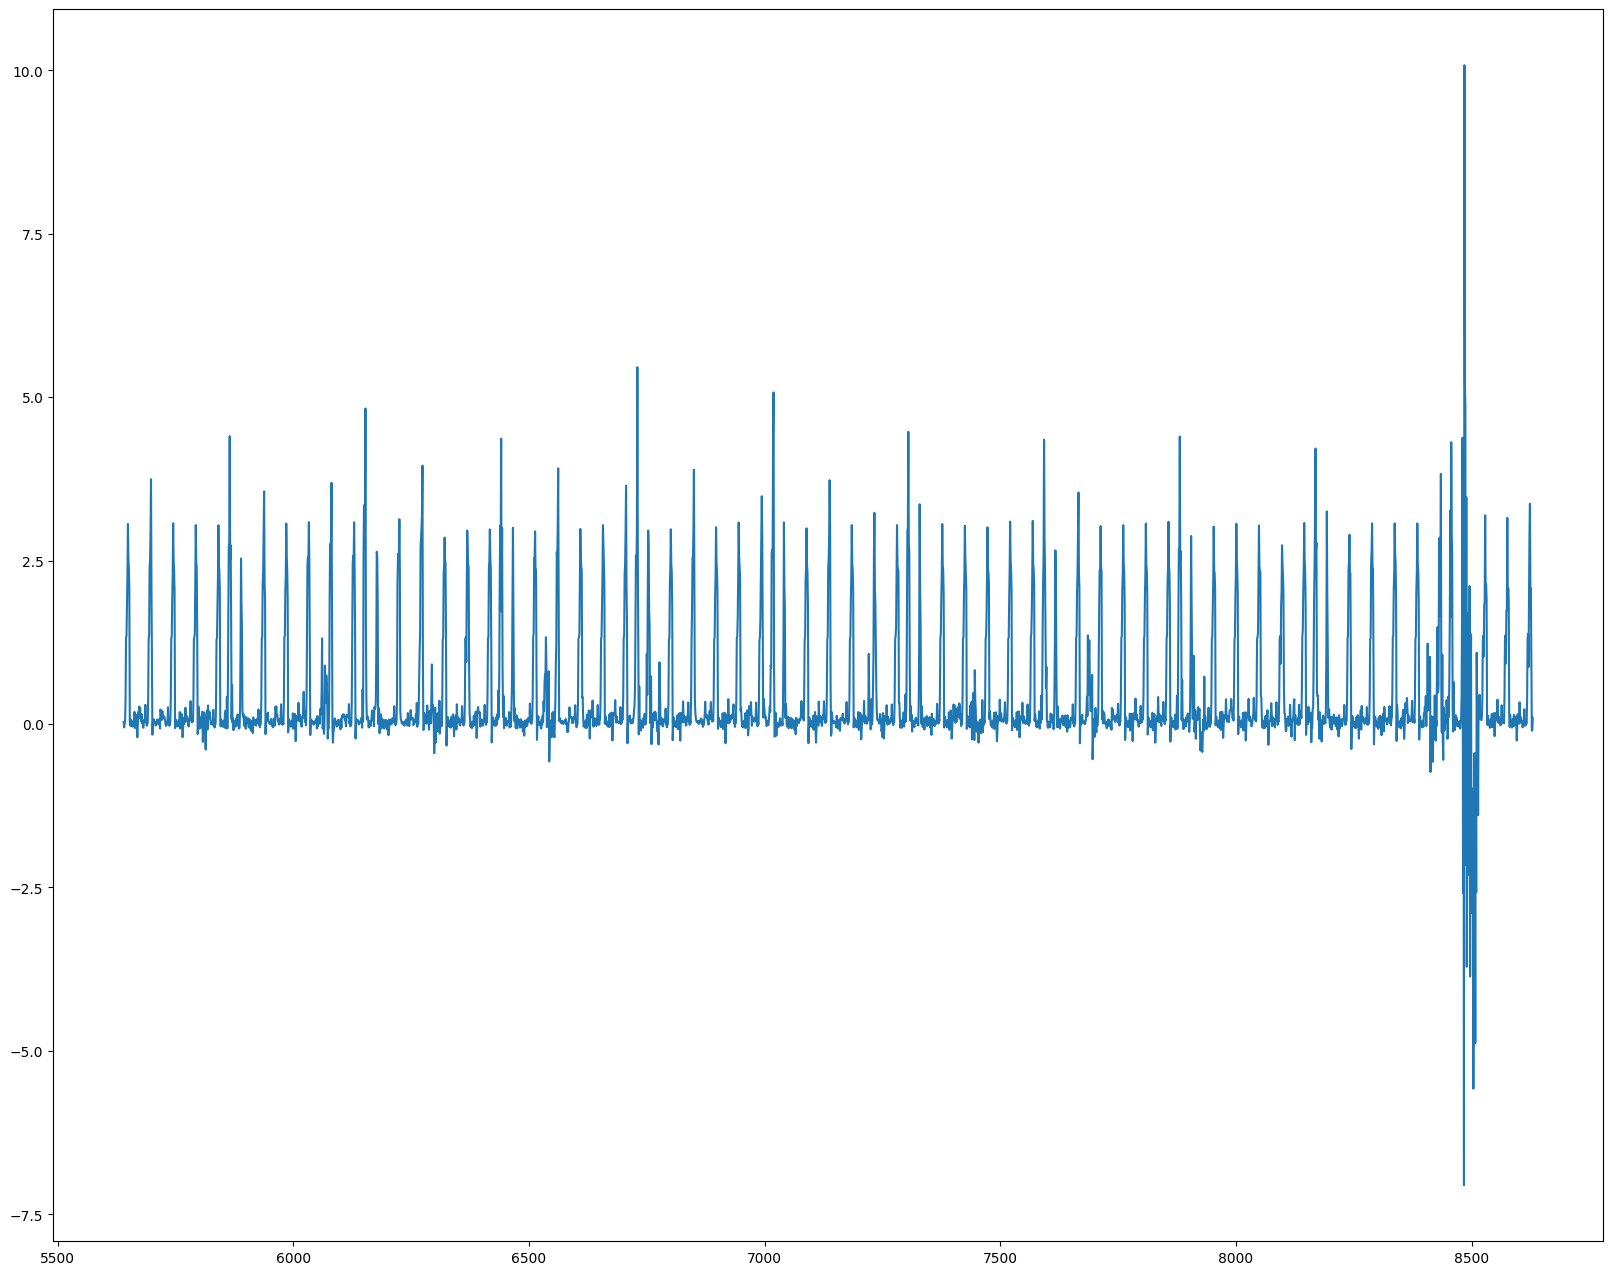

In [37]:
plt.figure()
plt.plot(testPredictPlot)
plt.show()

Adding Index column

In [38]:
df.reset_index(inplace=True)

In [39]:
df

,index,Timestamp [ms],CPU cores,CPU capacity provisioned [MHZ],CPU usage [MHZ],CPU usage [%],Memory capacity provisioned [KB],Memory usage [KB],Disk read throughput [KB/s],Disk write throughput [KB/s],Network received throughput [KB/s],Network transmitted throughput [KB/s],Disk I/O
0,0,1376314846,2,5851.998636,3.901332,0.066667,2097152.0,106254.133333,7.933333,1.066667,0.000000,0.000000,0.022571
1,1,1376315146,2,5851.998636,0.000000,0.000000,2097152.0,79689.600000,0.000000,1.000000,0.000000,0.000000,0.002508
2,2,1376315446,2,5851.998636,9.753331,0.166667,2097152.0,62912.000000,0.000000,0.066667,0.000000,0.000000,0.000167
3,3,1376315746,2,5851.998636,0.000000,0.000000,2097152.0,97865.333333,0.000000,0.066667,0.000000,0.000000,0.000167
4,4,1376316046,2,5851.998636,0.000000,0.000000,2097152.0,127225.333333,1.933333,0.333333,0.000000,0.000000,0.005684
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8627,8627,1378905598,2,5851.998944,76.075986,1.300000,2097152.0,329950.133333,0.333333,561.866667,581.800000,18.400000,1.409906
8628,8628,1378905898,2,5851.998944,54.618657,0.933333,2097152.0,244665.333333,1.800000,1.133333,2.466667,1.066667,0.007356
8629,8629,1378906198,2,5851.998944,58.519989,1.000000,2097152.0,139808.800000,0.200000,0.866667,2.400000,1.066667,0.002675
8630,8630,1378906498,2,5851.998944,325.761275,5.566667,2097152.0,325755.733333,1029.666667,55.466667,2.466667,1.533333,2.721338


In [40]:
time_list = df['index'].tolist()

In [41]:
time_array = np.array(time_list)

# PLotting the data

In [42]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time", fontsize=15)
    plt.ylabel("Disk Usages", fontsize=15)
    plt.grid(True)

In [43]:
train=scaler.inverse_transform(train)

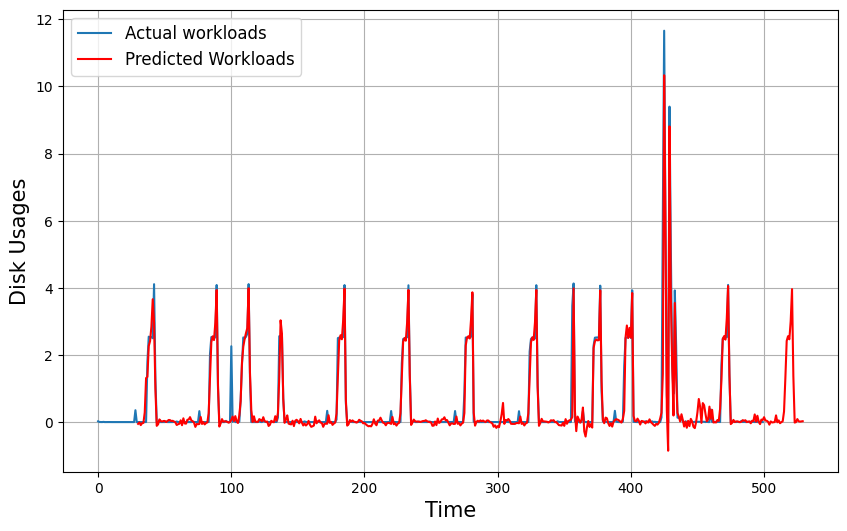

In [44]:
plt.figure(figsize=(10, 6))
plot_series(time_array[0:500],train[:500,0])
plot_series(time_array[30:530],trainPredict[:500,0],'r' )
plt.legend(('Actual workloads', 'Predicted Workloads'),fontsize=12)
plt.savefig('3 day disk pred.png', dpi = 1080)

We have shown 104 hours 4 munits of data distribution from train dataset where prediction curves catches all the trends. we have also forcasted future disk usage of 1 hour 4 min.

In [45]:
test = scaler.inverse_transform(test)

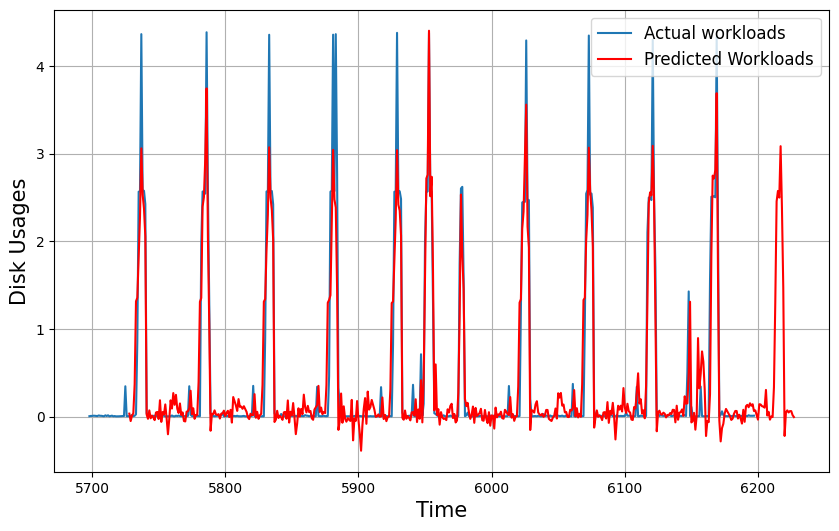

In [46]:
plt.figure(figsize=(10, 6))
plot_series(time_array[5698:6198],test[:500,0])
plot_series(time_array[5698+30:6198+30],testPredict[:500,0],'r' )
plt.legend(('Actual workloads', 'Predicted Workloads'),fontsize=12)
plt.savefig('3 day disk pred.png', dpi = 1080)

We have shown 104 hours 4 munits of data distribution from test dataset where prediction curves catches all the trends. we have also forcasted future disk usage of 1 hour 4 min.